# [FastSurfer](https://github.com/nikhil153/FastSurfer) model performance analysis 

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Output
- FastCNN segmentations (DKT)
- FastRecon surface measures (DKT)
    - uses aparcstats2table command from FreeSurfer to calculate group summaries
    - FreeSurfer:
        - export SUBJECTS_DIR=../../green_compute/ukb_pilot/freesurfer/
        - aparcstats2table --subjectsfile ../subject_lists/subject_dirs.txt --hemi rh --meas thickness --tablefile ../FastSurfer_experiments/results/aparc_CT_rh.txt --skip
    - Fastsurfer: 
        - export SUBJECTS_DIR=../../green_compute/ukb_pilot/fastsurfer/prune_0/
        - aparcstats2table --subjectsfile ../subject_lists/subject_dirs.txt -p aparc.mapped --hemi lh --meas thickness --tablefile ../FastSurfer_experiments/results/aparc_CT_lh.txt --skip

## Current exporatory analysis:
- model pruning 

## Perfomance measures
- dice for DKT volumetric segmentation

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import compute, delayed
import dask.multiprocessing

sys.path.append('../../')
sys.path.append('../')
from lib.fastsurfer_utils import *


## Paths

In [2]:
project_dir = '../'
exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
results_dir = '{}results/prunning/'.format(exp_dir)

### Rough work (sample file converstion)
### Needed to visualize in itksnap

In [ ]:
# mgz_file = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz" #"/home/nikhil/Downloads/orig.mgz"   #aparc.DKTatlas+aseg.deep.mgz"
# mgz_file = "/home/nikhil/Desktop/orig.mgz" 
# convert_mgz_to_nifti(mgz_file)

## FastCNN segmentations and pruning performance

## Sample single subject case

In [ ]:
FreeSurfer_label = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz"

FastSurfer_label_dict = {'orig': '/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep.mgz', 
                     'prune_50':'/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep_prune_50.mgz'}

fs_seg = nib.load(FreeSurfer_label).get_fdata()
unique_labels = set(fs_seg.ravel())
print('{} unique labels found'.format(len(unique_labels)))

dice_df_concat = pd.DataFrame()

for prune, FastSurfer_label in FastSurfer_label_dict.items(): 
    print('Prune: {}'.format(prune))
    deep_seg = nib.load(FastSurfer_label).get_fdata()
    dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
    dice_df['pruning'] = prune
    dice_df_concat = dice_df_concat.append(dice_df)


In [ ]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='pruning', kind='point', data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)

## Cohort performances

In [ ]:
# mni dataset
# FreeSurfer_label_dir = '/home/nikhil/projects/Parkinsons/data/fs60/segmentations/'
# FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/data/'

# ukb dataset
cohort = 'ukb'
FreeSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/output/fs6.0/ukb/DKT_labels/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/output/ukb/FastCNN/'


ignore_subjects = {'sub-1009760'}

In [ ]:
run = 'run_2'
procs  = ['gpu']
prunnings = ['prune_0'] #,'prune_25','prune_50'] 
save_perf = False

for proc in procs:
    print('Starting with run:{} and proc: {}'.format(run, proc))
    perf_dir = '{}/{}/{}/{}/'.format(results_dir,cohort,run,proc)
    print('Saving perf at: {}'.format(perf_dir))

    for prunning in prunnings:
        print('\nStarting with pruning: {}'.format(prunning))
        FreeSurfer_subjects = os.listdir('{}'.format(FreeSurfer_label_dir))
        FastSurfer_subjects = os.listdir('{}/{}/{}/{}'.format(FastSurfer_label_dir, run, proc, prunning))
        common_subject = list(set(FastSurfer_subjects) & set(FreeSurfer_subjects) - ignore_subjects)

        print('n subjects\nFreeSurfer:{}, FastSurfer:{}, common:{}'.format(len(FreeSurfer_subjects), len(FastSurfer_subjects), len(common_subject)))

        dice_df_concat = pd.DataFrame()
        unique_labels = None
        for s, sub in enumerate(common_subject):
            print('Subject id: {},{}'.format(s,sub))
            FreeSurfer_label = FreeSurfer_label_dir + '{}/aparc.DKTatlas+aseg.mgz'.format(sub)
            FastSurfer_label = FastSurfer_label_dir + '{}/{}/{}/{}/aparc.DKTatlas+aseg.deep.mgz'.format(run,proc,prunning,sub)

            try:
                fs_seg = nib.load(FreeSurfer_label).get_fdata()
                deep_seg = nib.load(FastSurfer_label).get_fdata()

                if unique_labels == None:
                    unique_labels = set(fs_seg.ravel())
                    print('{} unique labels found'.format(len(unique_labels)))

                dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
                dice_df['prunning'] = prunning
                dice_df['cohort'] = cohort
                dice_df['subject_id'] = sub
                dice_df_concat = dice_df_concat.append(dice_df)

            except Exception as e: 
                print(e)
                continue

        if save_perf:
            dice_csv = perf_dir + '{}/dice_perf.csv'.format(prunning)
            dice_df_concat.to_csv(dice_csv)




## Load previously saved perf

In [ ]:
dice_df_concat = pd.DataFrame()
cohorts = ['ukb'] #['NC,'ET','PD']
runs = ['run_1','run_2']
procs = ['cpu','gpu']
prunnings = ['prune_0','prune_25','prune_50'] #

for cohort in cohorts:
    for run in runs:
        for proc in procs:        
            for prunning in prunnings:
                perf_dir = '{}/{}/{}/{}/{}/'.format(results_dir,cohort,run,proc,prunning)
                dice_csv = perf_dir + 'dice_perf.csv'
                if os.path.isfile(dice_csv):
                    dice_df = pd.read_csv(dice_csv)
                    dice_df['cohort'] = cohort
                    dice_df['run'] = run
                    dice_df['proc'] = proc
                    dice_df['prunning'] = prunning
                    dice_df_concat = dice_df_concat.append(dice_df)
                else:
                    print('{} does not exist'.format(dice_csv))

In [ ]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
hue_order = prunnings
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', col='run', col_wrap=1, kind='point', hue_order=hue_order ,data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50,fontsize=12)



In [ ]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
# hue_order = runs
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='proc', col='run', kind='box', data=plot_df, palette='Set2', order=x_order, height=5, aspect=2, sharex=True, sharey=True)
    


## Filter performance of stable ROIs

In [ ]:
dice_thresh = 0.85
label_df = dice_df_concat[dice_df_concat['prunning']=='prune_0'].groupby(['label']).median().reset_index()
stable_ROIs = label_df[label_df['dice']>dice_thresh]['label'].unique()
print('theshold: {}, number of stable ROIs: {}'.format(dice_thresh, len(stable_ROIs)))

In [ ]:
plot_df = dice_df_concat.copy()
print(plot_df.shape)
plot_df = plot_df[plot_df['label'].isin(stable_ROIs)]
print(plot_df.shape)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', kind='box', data=plot_df, palette='Set2', height=5, aspect=4, sharex=True, sharey=True)

## Recon-surf performance
- Compare cortical thickness (correlation)

In [5]:
# ukb dataset
cohort = 'ukb'
FreeSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/watts_up_compute/preproc_pipeline_experiments/results/recon-surf/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/watts_up_compute/FastSurfer_experiments/results/recon-surf/'

ignore_subjects = {'sub-1009760'}

In [40]:
FreeSurfer_CT_file = FreeSurfer_label_dir + 'DKT_CT_lh.txt'
FreeSurfer_CT_L = pd.read_csv(FreeSurfer_CT_file, sep='\t')
FreeSurfer_CT_L = FreeSurfer_CT_L.rename(columns={'lh.aparc.DKTatlas.thickness':'subject_id'}).set_index('subject_id')

FreeSurfer_CT_file = FreeSurfer_label_dir + 'DKT_CT_rh.txt'
FreeSurfer_CT_R = pd.read_csv(FreeSurfer_CT_file, sep='\t')
FreeSurfer_CT_R = FreeSurfer_CT_R.rename(columns={'rh.aparc.DKTatlas.thickness':'subject_id'}).set_index('subject_id')

FreeSurfer_CT = pd.concat([FreeSurfer_CT_L,FreeSurfer_CT_R], axis=1)

FastSurfer_CT_file = FastSurfer_label_dir + 'aparc_CT_lh.txt'
FastSurfer_CT_L = pd.read_csv(FastSurfer_CT_file, sep='\t')
FastSurfer_CT_L = FastSurfer_CT_L.rename(columns={'lh.aparc.mapped.thickness':'subject_id'}).set_index('subject_id')

FastSurfer_CT_file = FastSurfer_label_dir + 'aparc_CT_rh.txt'
FastSurfer_CT_R = pd.read_csv(FastSurfer_CT_file, sep='\t')
FastSurfer_CT_R = FastSurfer_CT_R.rename(columns={'rh.aparc.mapped.thickness':'subject_id'}).set_index('subject_id')

FastSurfer_CT = pd.concat([FastSurfer_CT_L,FastSurfer_CT_R], axis=1)

corr_df = pd.DataFrame(FastSurfer_CT.corrwith(FreeSurfer_CT, axis=0)).reset_index()
corr_df.columns = ['ROI_str','correlation']
corr_df['ROI'] = corr_df['ROI_str'].str.split('_',expand=True)[1]
corr_df['hemi'] = corr_df['ROI_str'].str.split('_',expand=True)[0]

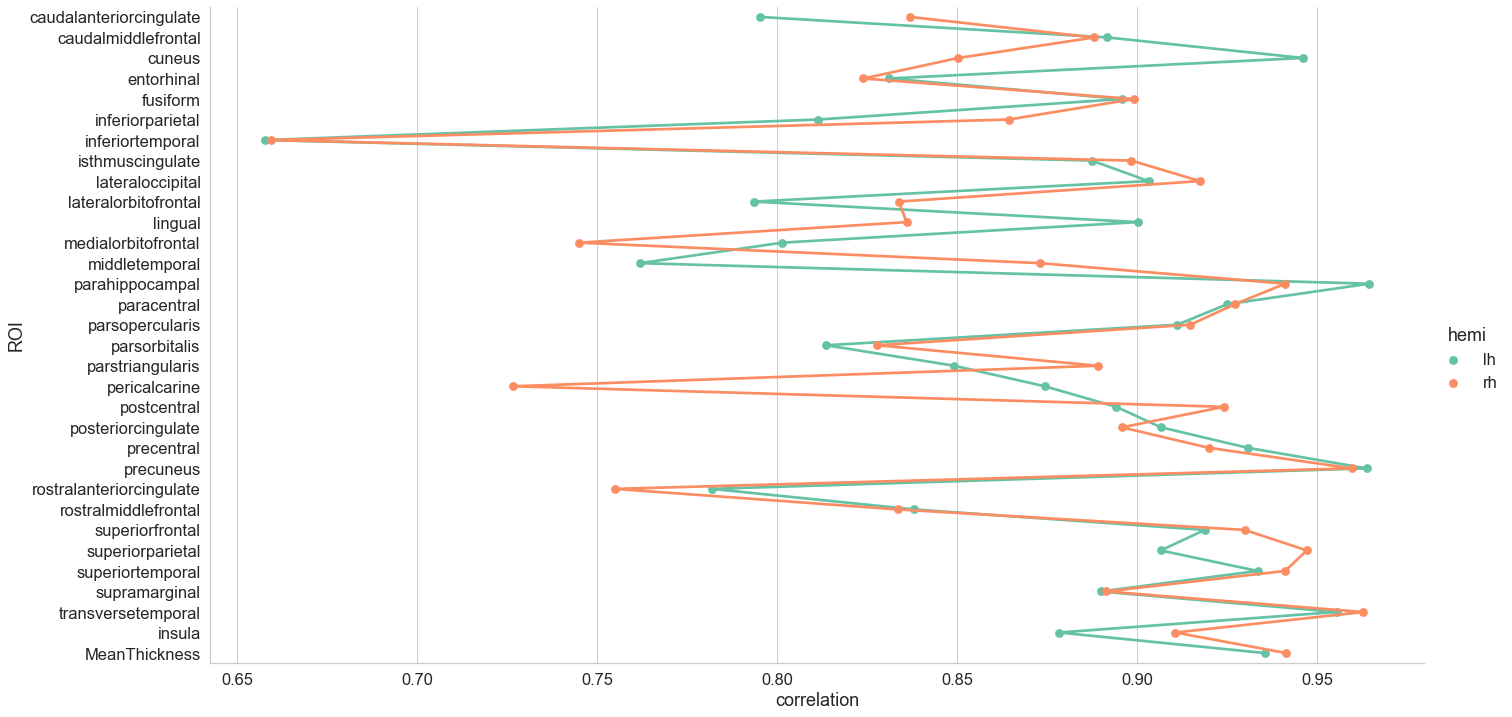

In [49]:
plot_df = corr_df.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='ROI',x='correlation', hue='hemi', kind='point', data=plot_df, palette='Set2', height=10, aspect=2)
    # g.set_xticklabels(rotation=40,fontsize=16)